In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
import math
from torch.utils.data import  DataLoader
from torchvision import models
import torchvision

import torchvision.transforms as transforms
import torchvision.datasets as dataset

import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import random
from time import time
import os
import warnings
warnings.filterwarnings('ignore')

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [ ]:
!pip install foolbox
import foolbox as fb

     |████████████████████████████████| 1.7MB 6.9MB/s 
     |████████████████████████████████| 61kB 4.4MB/s 
     |████████████████████████████████| 163kB 18.4MB/s 
     |████████████████████████████████| 71kB 4.6MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
def occlusion(model, image, label, occ_size = 50, occ_stride = 50, occ_pixel = 0.5):
  
    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]
  
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
  
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))
    k=0
    plt.figure(figsize=(12,10))
    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            input_image = image.clone().detach()
            
            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel

            
            k+=1
            img = input_image[0].cpu() / 2 + 0.5     # unnormalize 
            npimg = img.numpy()
            npimg = np.transpose(npimg,(1,2,0))
            plt.subplot(4,4,k)
            plt.imshow(npimg)
            
            #run inference on modified image
            output = model(input_image)
            output = nn.functional.softmax(output, dim=1)
            prob = output.tolist()[0][label]
            
            #setting the heatmap location to probability value
            heatmap[h, w] = prob 

    return heatmap

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=True, num_workers=2)


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
## My CNN class
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.conv7 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.pool(F.relu(self.bn8(self.conv8(x))))
        x = x.view(-1, 512)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

convNet = ConvNet()
convNet.to(device)
print(convNet)
print("Number of paramters in ConvNet: " + str(count_parameters(convNet)))

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
## Create empty lists to be populated during training
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

In [ ]:
## This function calculates the test set loss and accuracy
def calculate_test_score(data_loader, loss_list = [], acc_list = [], log = False):
    
    convNet.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = convNet(data)
            test_loss += F.cross_entropy(output, target).item()  # mean batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(data_loader)

    if log:
        print('Test set - Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(data_loader.dataset),
            100. * correct / len(data_loader.dataset)))
    loss_list.append(test_loss)
    acc_list.append(correct/len(data_loader.dataset))
    return loss_list, acc_list

## This function saves the model to a .pt file 
def save_model(num_epoch):
    torch.save(convNet, "model_epoch_" + str(num_epoch) + ".pt")

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convNet.parameters(), lr=0.003)

## Actual training

time_start = time()
print("Starting training...")
for epoch in range(10):
    convNet.train()
    running_loss = 0
    correct = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = convNet(inputs)
        
        loss = criterion(outputs, labels)
        running_loss+=loss.item()
        loss.backward()
        optimizer.step()
        
        pred = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
    
    print("Epoch " + str(epoch+1) + " completed. Training loss: " + str(running_loss/len(train_loader)))
    train_loss_list.append(running_loss/len(train_loader))
    train_acc_list.append(correct/len(train_loader.dataset))
    test_loss_list, test_acc_list = calculate_test_score(test_loader, test_loss_list, test_acc_list, log = True)
    save_model(epoch+1)
training_time = time()-time_start
print("Training completed.")
print("Total training time: " + str(int(training_time/60)) + "m " + str(int(training_time%60)) + "s")

Starting training...
Epoch 1 completed. Training loss: 2.2240970745654116
Test set - Average loss: 1.9728, Accuracy: 2092/10000 (21%)

Epoch 2 completed. Training loss: 1.9568587108369218
Test set - Average loss: 1.8752, Accuracy: 2505/10000 (25%)

Epoch 3 completed. Training loss: 1.7517722211277644
Test set - Average loss: 1.4879, Accuracy: 4102/10000 (41%)



KeyboardInterrupt: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
convNet = torch.load("/content/drive/MyDrive/CS 680/model_epoch_10.pt")
#convNet = torch.load("/content/drive/MyDrive/model_cifar.pt")

In [ ]:
calculate_test_score(test_loader)

([0.6810309941681049], [0.7842])

In [ ]:
len(trainset)

50000

In [ ]:
experiment = torchvision.datasets.CIFAR10(root='./', train=True,
                                        download=True, transform=transform)
experiment = torch.utils.data.Subset(experiment, range(0,1000))
experiment_loader = torch.utils.data.DataLoader(experiment, batch_size=1,
                                          shuffle=True, num_workers=2)

#all data
experiment_loader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [ ]:
'''os.mkdir("Occulsion")
os.chdir("Occulsion")
os.mkdir("adv")
os.mkdir("normal")'''

In [ ]:
fmodel = fb.PyTorchModel(convNet.eval(),(0,1),device=device)
attack = fb.attacks.FGSM()
# attack = fb.attacks.LinfDeepFoolAttack()


In [ ]:
normal = dict()
adv = dict()

for i in range(10):
  normal[i] = []
  adv[i] = []

for i,target in tqdm(experiment_loader):
  label = convNet(i.cuda())
  label = torch.argmax(label,1)
  if label.item() == target.item():
    hm = occlusion(convNet,i.cuda(),target.item(),15,5)
    normal[label.item()].append(hm)

    raw, clipped, is_adv = attack(fmodel,i.cuda(),target.cuda(),epsilons=0.3)
    label = convNet(clipped.cuda())
    label = torch.argmax(label,1)
    if label.item()!=target.item():
      hm = occlusion(convNet,clipped.cuda(),label.item(),15,5)
      adv[label.item()].append(hm)



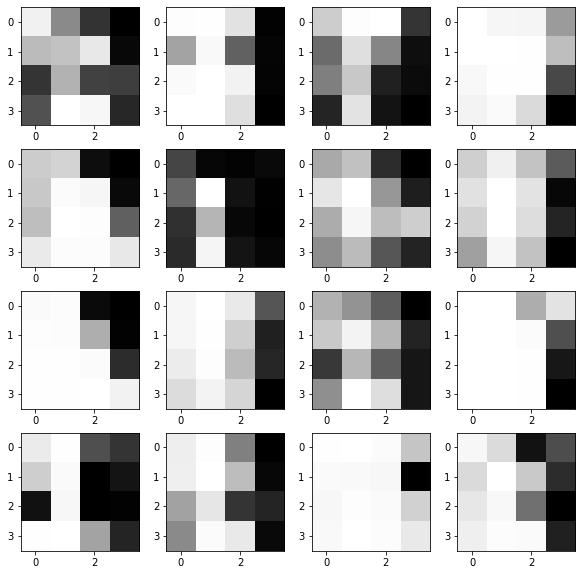

In [ ]:
plt.figure(figsize=(10,10))
for k in range(1,17):
  plt.subplot(4,4,k)
  plt.imshow(normal[9][k],cmap='gray')

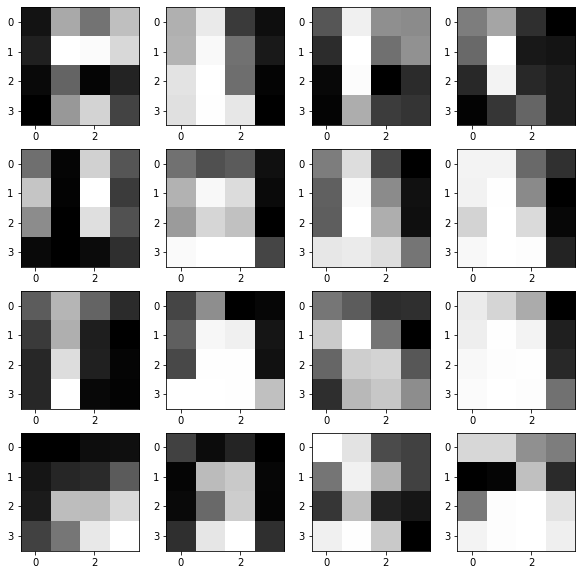

In [ ]:
plt.figure(figsize=(10,10))
for k in range(1,17):
  plt.subplot(4,4,k)
  plt.imshow(adv[9][k],cmap='gray')

In [ ]:
#Write out
import pickle
normal_file = open("normal_cif.pkl", "wb")
adv_file = open("adv_cif.pkl","wb")
pickle.dump(normal,normal_file)
pickle.dump(adv,adv_file)
normal_file.close()
adv_file.close()

In [ ]:
! cp adv_cif.pkl /content/drive/MyDrive/CS\ 680/
! cp normal_cif.pkl /content/drive/MyDrive/CS\ 680/

In [ ]:
#Read in
import pickle
normal_file = open("/content/drive/MyDrive/CS680/normal_cif.pkl", "rb")
adv_file = open("/content/drive/MyDrive/CS680/adv_cif.pkl","rb")

# normal_file = open("/content/drive/MyDrive/CS 680/normal_cif.pkl", "rb")
# adv_file = open("/content/drive/MyDrive/CS 680/adv_cif.pkl","rb")


normal = pickle.load(normal_file)
adv = pickle.load(adv_file)
normal_file.close()
adv_file.close()

In [ ]:
for i in range(10):
  print(i,len(normal[i]),len(adv[i]))

0 4586 699
1 4860 977
2 4430 6637
3 3669 2367
4 3963 5785
5 3630 337
6 4593 18211
7 4364 441
8 4562 1145
9 4641 1237


In [ ]:
## My CNN class
class Advnet(nn.Module):
    def __init__(self):
        super(Advnet, self).__init__()
        self.fc1 = nn.Linear(16, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1)

        self.log = nn.Sigmoid()
        

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.fc6(x)
        x = self.log(x)
        return x

advnet = Advnet()
print(advnet)
print("Number of paramters in ConvNet: " + str(count_parameters(advnet)))

Advnet(
  (fc1): Linear(in_features=16, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=1, bias=True)
  (log): Sigmoid()
)
Number of paramters in ConvNet: 113409


In [ ]:
for j in range(10):    
    data_normal = [x.flatten() for x in normal[j]]
    data_normal = torch.stack(data_normal)
    normal_targets = torch.zeros(len(data_normal)).reshape(-1,1)

    data_adv = [x.flatten() for x in adv[j]]
    data_adv = torch.stack(data_adv)
    adv_targets = torch.ones(len(data_adv)).reshape(-1,1)

    data_train = torch.vstack((data_adv[100:],data_normal[100:]))
    targets_train = torch.vstack((adv_targets[100:],normal_targets[100:]))

    data_test = torch.vstack((data_adv[:100],data_normal[:100]))
    targets_test = torch.vstack((adv_targets[:100],normal_targets[:100]))

    advnet = Advnet()

    #Train advnet
    loss = nn.BCELoss()
    optimizer = optim.Adam(advnet.parameters())
    for i in range(200):
        y = advnet(data_train)
        l = loss(y,targets_train)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print(j,sum(torch.round(advnet(data_test))==targets_test)/len(data_test))


0 tensor([0.6500])
1 tensor([0.6350])
2 tensor([0.6750])
3 tensor([0.6900])
4 tensor([0.7050])
5 tensor([0.5000])
6 tensor([0.5650])
7 tensor([0.5650])
8 tensor([0.7350])
9 tensor([0.6800])


In [ ]:
train

200

In [ ]:
x,t = next(iter(train_loader))

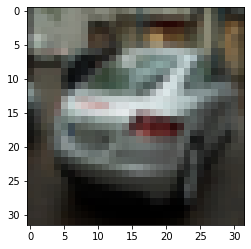

In [ ]:
imshow(x[0])

In [ ]:
y = torch.argmax(convNet(x.cuda()),1)
y

tensor([1], device='cuda:0')

In [ ]:
t

tensor([1])

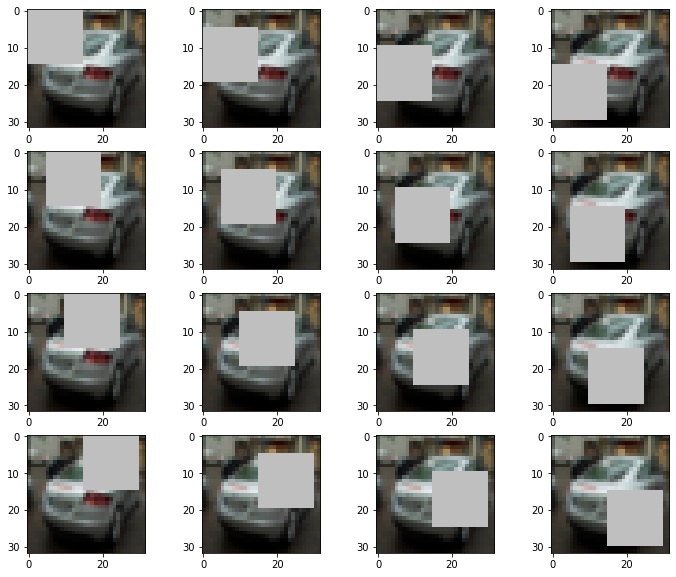

In [ ]:
hm = occlusion(convNet,x.cuda(),t.cuda(),15,5)

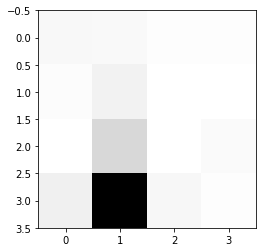

In [ ]:
plt.imshow(hm,cmap='gray')